In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets
!pip install nltk
!pip install --quiet -U accelerate
!pip install --quiet -U transformers
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4f29f03f9cb094cfd74c5576d1867a17cef0199390197c3195fd21433b6a56ac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import datasets
import transformers
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer,pipeline,AutoTokenizer,DataCollatorForSeq2Seq
import pickle

In [ ]:
data = load_dataset("cnn_dailymail",  "3.0.0", split="train[:2%]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
cnn = data.train_test_split(test_size=0.1)
cnn

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 5167
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 575
    })
})

In [ ]:
train_data = cnn['train']
val_data = cnn['test']

In [ ]:
checkpoint = "bert-base-uncased"
#tokenizer = AutoTokenizer.from_pretrained(checkpoint)
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(checkpoint)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

In [ ]:
batch_size=4  # change to 16 for full training
encoder_max_length=512
decoder_max_length=128

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`.
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

# only use 32 training examples for notebook - DELETE LINE FOR FULL TRAINING
train_data = train_data.select(range(32))

train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)


# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
#val_data = val_data.select(range(16))

val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [ ]:
from transformers import EncoderDecoderModel

bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained(checkpoint, checkpoint)

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [ ]:
#import tensorflow.python.keras.utils.vis_utils
#import tensorflow as tf
#from keras.utils.vis_utils import plot_model
#tf.keras.utils.plot_model(bert2bert, show_shapes=True, dpi=48)

In [ ]:
# set special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 120
bert2bert.config.min_length = 30
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
import evaluate
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# set training arguments - these params are not really tuned, feel free to change
def prepareTrainingArgs(optimizer, lr_rate, max_len):
  return Seq2SeqTrainingArguments(
      generation_max_length=max_len,
      output_dir="./",
      overwrite_output_dir=True,
      optim = optimizer, #adamw_torch, rmsprop, adagrad
      learning_rate=lr_rate, # 1e-4, 3e-4, 4e-4, 5e-4
      per_device_train_batch_size=12, #16, 32,
      per_device_eval_batch_size=12, #16, 32,
      weight_decay=0.01,
      seed =42,
      run_name=f"bert-training-{optimizer}-{lr_rate}-{max_len}",
      evaluation_strategy="steps", # 'epoch', 'steps'
      max_steps =2000,
      eval_steps = 100,
      save_strategy='steps',
      save_steps =1000,
      logging_dir=f"./",
      logging_strategy='steps',
      logging_steps=100,
      save_total_limit=1,
      num_train_epochs=1,  #3,5
      predict_with_generate=True,
      fp16=True,
      push_to_hub=False,
      disable_tqdm = False,
      report_to = 'none',  # wandb, tensorhub, none
  )



In [ ]:
def exec_training(training_args, optimizer, lr_rate, max_len):
    trainer = Seq2SeqTrainer(
      model=bert2bert,
      args=training_args,
      train_dataset=train_data,
      eval_dataset=val_data,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.evaluate()
    trainer_state = trainer.state.log_history
    with open(f"/content/drive/MyDrive/logs/state/bert-{optimizer}-{lr_rate}-{max_len}.pickle", 'wb') as f:
      pickle.dump(trainer_state, f)
    return trainer


In [ ]:
# Execute the training for different learning rates for AdamW optimiser and save the training metrics
optimizers = ['adamw_torch', 'adafactor']
learning_rates = [1e-4, 2e-4,]
max_length = [30, 40]

#optimizers = ['adafactor']
#learning_rates = [1e-4]
#max_length = [40]

index = len(learning_rates) * len(optimizers) * len(max_length)
print(index)
for opt_idx in range(len(optimizers)):
  for lr_idx in range(len(learning_rates)):
    for ml_idx in range(len(max_length)):
        print("ml-idx:", max_length[ml_idx], " lr_idx:", learning_rates[lr_idx], " opt_idx:", optimizers[opt_idx])
        train_args = prepareTrainingArgs(optimizers[opt_idx], learning_rates[lr_idx], max_length[ml_idx])
        exec_training(train_args, optimizers[opt_idx], learning_rates[lr_idx], max_length[ml_idx])


8
ml-idx: 30  lr_idx: 0.0001  opt_idx: adamw_torch


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:636: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warn

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
100,0.410900,0.001027,0.001500,0.000000,0.001500,0.001500,30.000000
200,0.008000,0.004471,0.000000,0.000000,0.000000,0.000000,30.000000
300,0.001000,0.001858,0.000200,0.000000,0.000200,0.000200,30.000000
400,0.018700,0.014368,0.003300,0.000000,0.003200,0.003300,30.000000
500,0.001900,0.006535,0.001000,0.000000,0.001000,0.001000,30.000000
600,0.008800,0.007245,0.010700,0.000000,0.009700,0.009800,30.000000
700,0.002400,0.010969,0.035000,0.001400,0.028400,0.028500,30.000000
800,0.000800,0.008598,0.000300,0.000000,0.000300,0.000300,30.000000
900,0.006900,0.014464,0.007800,0.000000,0.007600,0.007500,30.000000
1000,0.000300,0.011345,0.005800,0.000000,0.005200,0.005100,30.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 120, 'min_length': 30, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.cls.predictions.decoder.bias', 'decoder.cls.predictions.decoder.wei

KeyboardInterrupt: 

### Visualization of Fine Tuning Loss Metrics

In [1]:
from matplotlib.pylab import plt
from numpy import arange
import numpy as np
import pandas as pd

In [2]:
def getState(optimizer, lr_rate, max_length):
    print("ml-idx:", max_length, " lr_idx:", lr_rate, " opt_idx:", optimizer)
    trainer_state_df = pd.read_csv(f"./logs/fine_tuning/bert/bert-{optimizer}-{lr_rate}-{max_length}.csv")
    return trainer_state_df

def cleanseData(df):
    cols = ['loss','grad_norm','learning_rate']
    df.loc[:,cols] = df.loc[:,cols].ffill()
    cols = ['eval_loss', 'eval_rouge1_precision', 'eval_rouge1_recall',
                  'eval_rouge1_fmeasure', 'eval_runtime',  'eval_samples_per_second',
                  'eval_steps_per_second']
    df.loc[:,cols] = df.loc[:,cols].bfill()
    df.rename(columns = {'loss':'Training Loss'}, inplace = True)
    return df


In [3]:
x_steps = np.arange(200,2500, 200)


In [4]:
# Execute the training for different learning rates for AdamW optimiser and save the training metrics
optimizers = ['adamw_torch', 'adafactor']
learning_rates = [1e-5, 1e-4]
max_length = [30, 40]

summary = {}
for opt_idx in range(len(optimizers)):
  for lr_idx in range(len(learning_rates)):
    for ml_idx in range(len(max_length)):
        trainer_state_df = getState(optimizers[opt_idx], learning_rates[lr_idx], max_length[ml_idx])

        key_tl = f"y-{opt_idx}-{lr_idx}-{ml_idx}-TL"
        key_vl = f"y-{opt_idx}-{lr_idx}-{ml_idx}-VL"

        key_tl_vals = trainer_state_df['train_loss']
        key_vl_vals = trainer_state_df['eval_loss']

        summary[key_tl] = key_tl_vals
        summary[key_vl] = key_vl_vals

ml-idx: 30  lr_idx: 1e-05  opt_idx: adamw_torch
ml-idx: 40  lr_idx: 1e-05  opt_idx: adamw_torch
ml-idx: 30  lr_idx: 0.0001  opt_idx: adamw_torch
ml-idx: 40  lr_idx: 0.0001  opt_idx: adamw_torch
ml-idx: 30  lr_idx: 1e-05  opt_idx: adafactor
ml-idx: 40  lr_idx: 1e-05  opt_idx: adafactor
ml-idx: 30  lr_idx: 0.0001  opt_idx: adafactor
ml-idx: 40  lr_idx: 0.0001  opt_idx: adafactor


In [5]:
summary.keys()
x_steps = np.arange(200,2500,200).tolist()

In [6]:
y1a = summary['y-0-0-0-TL']
y1b = summary['y-0-0-0-VL']
y1c = summary['y-1-0-0-TL']
y1d = summary['y-1-0-0-VL']

y2a = summary['y-0-0-1-TL']
y2b = summary['y-0-0-1-VL']
y2c = summary['y-1-0-1-TL']
y2d = summary['y-1-0-1-VL']

y3a = summary['y-0-1-0-TL']
y3b = summary['y-0-1-0-VL']
y3c = summary['y-1-1-0-TL']
y3d = summary['y-1-1-0-VL']

y4a = summary['y-0-1-1-TL']
y4b = summary['y-0-1-1-VL']
y4c = summary['y-1-1-1-TL']
y4d = summary['y-1-1-1-VL']

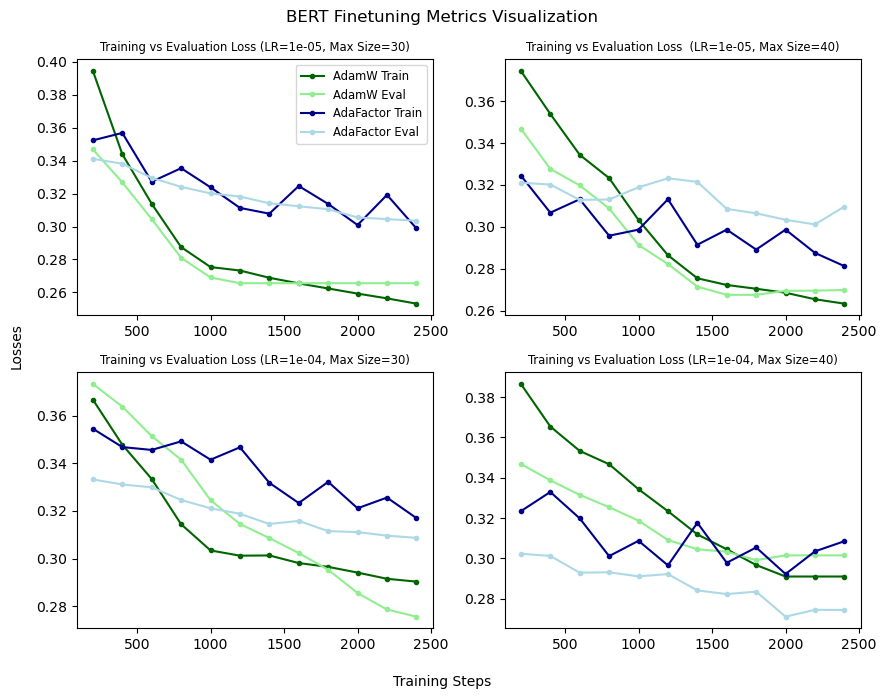

In [7]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(9, 7))

fig.supxlabel('Training Steps',fontsize='medium')
fig.supylabel('Losses',fontsize='medium')
fig.suptitle('BERT Finetuning Metrics Visualization')

adam_TL_color = 'darkgreen'
adam_EL_color = 'lightgreen'
ada_TL_color = 'darkblue'
ada_EL_color = 'lightblue'

# Plot data on each subplot
axs[0, 0].plot(x_steps, y1a, '.-', color = adam_TL_color, label='AdamW Train')
axs[0, 0].plot(x_steps, y1b, '.-', color = adam_EL_color, label='AdamW Eval')
axs[0, 0].plot(x_steps, y1c, '.-', color = ada_TL_color,  label='AdaFactor Train')
axs[0, 0].plot(x_steps, y1d, '.-', color = ada_EL_color,  label='AdaFactor Eval')
axs[0, 0].set_title('Training vs Evaluation Loss (LR=1e-05, Max Size=30)', fontsize='small', loc='center')
axs[0, 0].legend(fontsize='small')

axs[0, 1].plot(x_steps, y2a, '.-', color = adam_TL_color)
axs[0, 1].plot(x_steps, y2b, '.-', color = adam_EL_color)
axs[0, 1].plot(x_steps, y2c, '.-', color = ada_TL_color)
axs[0, 1].plot(x_steps, y2d,'.-', color = ada_EL_color)
axs[0, 1].set_title('Training vs Evaluation Loss  (LR=1e-05, Max Size=40)', fontsize='small', loc='center')

axs[1, 0].plot(x_steps, y3a,'.-', color = adam_TL_color)
axs[1, 0].plot(x_steps, y3b,'.-', color = adam_EL_color)
axs[1, 0].plot(x_steps, y3c,'.-', color = ada_TL_color)
axs[1, 0].plot(x_steps, y3d,'.-', color = ada_EL_color)
axs[1, 0].set_title('Training vs Evaluation Loss (LR=1e-04, Max Size=30)', fontsize='small', loc='center')

axs[1, 1].plot(x_steps, y4a,'.-', color = adam_TL_color)
axs[1, 1].plot(x_steps, y4b,'.-', color = adam_EL_color)
axs[1, 1].plot(x_steps, y4c, '.-', color = ada_TL_color)
axs[1, 1].plot(x_steps, y4d, '.-', color = ada_EL_color)
axs[1, 1].set_title('Training vs Evaluation Loss (LR=1e-04, Max Size=40)', fontsize='small', loc='center')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Visualization of ROUGE Score

In [20]:
rougeScore={}
cleaned_df = ""
for opt_idx in range(len(optimizers)):
  for lr_idx in range(len(learning_rates)):
    for ml_idx in range(len(max_length)):
        trainer_state_df = getState(optimizers[opt_idx], learning_rates[lr_idx], max_length[ml_idx])
        # parse list of dict or json and create graph of validation loss / training loss 
        # and trend of rougue metrics across steps/epics
        
        
        #cleaned_df = cleanseData(trainer_state_df)
        key_rl = f"y-{opt_idx}-{lr_idx}-{ml_idx}-ROUGE1"
        key_r2 = f"y-{opt_idx}-{lr_idx}-{ml_idx}-ROUGE2"
        key_rL = f"y-{opt_idx}-{lr_idx}-{ml_idx}-ROUGEL"
        
        key_rl_vals = trainer_state_df['eval_rouge1']
        key_r2_vals = trainer_state_df['eval_rouge2']
        key_rL_vals = trainer_state_df['eval_rougeL']
        
        rougeScore[key_rl] = key_rl_vals
        rougeScore[key_r2] = key_r2_vals
        rougeScore[key_rL] = key_rL_vals

ml-idx: 30  lr_idx: 1e-05  opt_idx: adamw_torch
ml-idx: 40  lr_idx: 1e-05  opt_idx: adamw_torch
ml-idx: 30  lr_idx: 0.0001  opt_idx: adamw_torch
ml-idx: 40  lr_idx: 0.0001  opt_idx: adamw_torch
ml-idx: 30  lr_idx: 1e-05  opt_idx: adafactor
ml-idx: 40  lr_idx: 1e-05  opt_idx: adafactor
ml-idx: 30  lr_idx: 0.0001  opt_idx: adafactor
ml-idx: 40  lr_idx: 0.0001  opt_idx: adafactor


In [21]:
rougeScore.keys()

dict_keys(['y-0-0-0-ROUGE1', 'y-0-0-0-ROUGE2', 'y-0-0-0-ROUGEL', 'y-0-0-1-ROUGE1', 'y-0-0-1-ROUGE2', 'y-0-0-1-ROUGEL', 'y-0-1-0-ROUGE1', 'y-0-1-0-ROUGE2', 'y-0-1-0-ROUGEL', 'y-0-1-1-ROUGE1', 'y-0-1-1-ROUGE2', 'y-0-1-1-ROUGEL', 'y-1-0-0-ROUGE1', 'y-1-0-0-ROUGE2', 'y-1-0-0-ROUGEL', 'y-1-0-1-ROUGE1', 'y-1-0-1-ROUGE2', 'y-1-0-1-ROUGEL', 'y-1-1-0-ROUGE1', 'y-1-1-0-ROUGE2', 'y-1-1-0-ROUGEL', 'y-1-1-1-ROUGE1', 'y-1-1-1-ROUGE2', 'y-1-1-1-ROUGEL'])

In [22]:
trainer_state_df.head(10)

,train_loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_rouge1,eval_rouge2,eval_rougeL,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss.1
0,0.32342,0.002358,0.000092,100,200,0.3023,0.3195,0.1278,0.2271,77.6233,7.408,0.464,NaN,NaN,NaN,NaN,NaN
1,0.33293,0.004239,0.000083,200,400,0.3012,0.3105,0.1231,0.2277,74.7695,7.690,0.481,NaN,NaN,NaN,NaN,NaN
2,0.31984,0.000188,0.000075,300,600,0.2929,0.3118,0.1207,0.2268,75.0549,7.661,0.480,NaN,NaN,NaN,NaN,NaN
3,0.30112,0.000244,0.000067,400,800,0.2931,0.3126,0.1236,0.2304,75.0985,7.657,0.479,NaN,NaN,NaN,NaN,NaN
4,0.30872,0.000061,0.000058,500,1000,0.2911,0.3167,0.1259,0.2269,76.2933,7.537,0.472,NaN,NaN,NaN,NaN,NaN
5,0.29653,0.000059,0.000050,600,1200,0.2922,0.3182,0.1287,0.2265,76.2431,7.542,0.472,NaN,NaN,NaN,NaN,NaN
6,0.31764,0.000150,0.000042,700,1400,0.2841,0.3127,0.1225,0.2234,74.7985,7.687,0.481,NaN,NaN,NaN,NaN,NaN
7,0.29782,0.000113,0.000034,800,1600,0.2823,0.3131,0.1341,0.2342,75.9665,7.569,0.474,NaN,NaN,NaN,NaN,NaN
8,0.30541,0.000038,0.000025,900,1800,0.2835,0.3118,0.1326,0.2407,76.2074,7.545,0.472,NaN,NaN,NaN,NaN,NaN
9,0.29224,0.000029,0.000017,1000,2000,0.2711,0.3143,0.1358,0.2442,75.6811,7.598,0.476,NaN,NaN,NaN,NaN,NaN


In [23]:
x_steps = np.arange(200,2500,200).tolist()
len(x_steps)

12

In [24]:
y1a = rougeScore['y-0-0-0-ROUGE1']
y1b = rougeScore['y-0-0-0-ROUGE2']
y1c = rougeScore['y-0-0-0-ROUGEL']
y1d = rougeScore['y-1-0-0-ROUGE1']
y1e = rougeScore['y-1-0-0-ROUGE2']
y1f = rougeScore['y-1-0-0-ROUGEL']

y2a = rougeScore['y-0-0-1-ROUGE1']
y2b = rougeScore['y-0-0-1-ROUGE2']
y2c = rougeScore['y-0-0-1-ROUGEL']
y2d = rougeScore['y-1-0-1-ROUGE1']
y2e = rougeScore['y-1-0-1-ROUGE2']
y2f = rougeScore['y-1-0-1-ROUGEL']

y3a = rougeScore['y-0-1-0-ROUGE1']
y3b = rougeScore['y-0-1-0-ROUGE2']
y3c = rougeScore['y-0-1-0-ROUGEL']
y3d = rougeScore['y-1-1-0-ROUGE1']
y3e = rougeScore['y-1-1-0-ROUGE2']
y3f = rougeScore['y-1-1-0-ROUGEL']

y4a = rougeScore['y-0-1-1-ROUGE1']
y4b = rougeScore['y-0-1-1-ROUGE2']
y4c = rougeScore['y-0-1-1-ROUGEL']
y4d = rougeScore['y-1-1-1-ROUGE1']
y4e = rougeScore['y-1-1-1-ROUGE2']
y4f = rougeScore['y-1-1-1-ROUGEL']

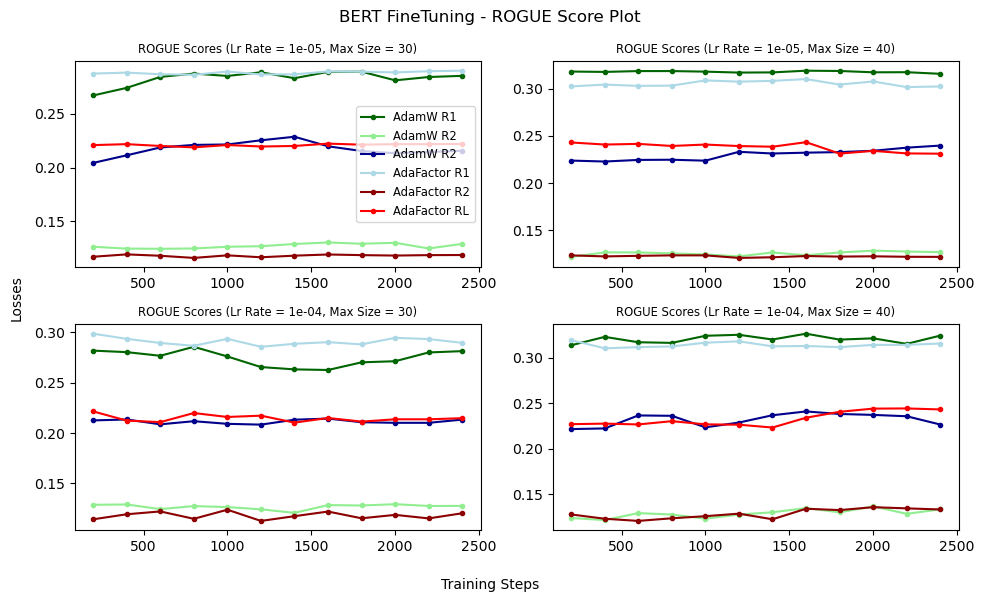

In [25]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

fig.supxlabel('Training Steps', fontsize='medium')
fig.supylabel('Losses', fontsize='medium')
fig.suptitle('BERT FineTuning - ROGUE Score Plot')

adam_R1_color = 'darkgreen'
ada_R1_color = 'lightgreen'
adam_R2_color = 'darkblue'
ada_R2_color = 'lightblue'
adam_RL_color = 'darkred'
ada_RL_color = 'red'

# Plot data on each subplot
axs[0, 0].plot(x_steps, y1a, '.-', color = adam_R1_color, label='AdamW R1')
axs[0, 0].plot(x_steps, y1b, '.-', color = ada_R1_color, label='AdamW R2')
axs[0, 0].plot(x_steps, y1c, '.-', color = adam_R2_color, label='AdamW R2')
axs[0, 0].plot(x_steps, y1d, '.-', color = ada_R2_color,  label='AdaFactor R1')
axs[0, 0].plot(x_steps, y1e, '.-', color = adam_RL_color,  label='AdaFactor R2')
axs[0, 0].plot(x_steps, y1f, '.-', color = ada_RL_color,  label='AdaFactor RL')
axs[0, 0].set_title('ROGUE Scores (Lr Rate = 1e-05, Max Size = 30)', fontsize='small', loc='center')
axs[0, 0].legend(fontsize='small')

axs[0, 1].plot(x_steps, y2a, '.-', color = adam_R1_color)
axs[0, 1].plot(x_steps, y2b, '.-', color = ada_R1_color)
axs[0, 1].plot(x_steps, y2c, '.-', color = adam_R2_color)
axs[0, 1].plot(x_steps, y2d, '.-', color = ada_R2_color)
axs[0, 1].plot(x_steps, y2e,'.-', color = adam_RL_color)
axs[0, 1].plot(x_steps, y2f,'.-', color = ada_RL_color)
axs[0, 1].set_title('ROGUE Scores (Lr Rate = 1e-05, Max Size = 40)', fontsize='small', loc='center')

axs[1, 0].plot(x_steps, y3a,'.-', color = adam_R1_color)
axs[1, 0].plot(x_steps, y3b,'.-', color = ada_R1_color)
axs[1, 0].plot(x_steps, y3c,'.-', color = adam_R2_color)
axs[1, 0].plot(x_steps, y3d,'.-', color = ada_R2_color)
axs[1, 0].plot(x_steps, y3e,'.-', color = adam_RL_color)
axs[1, 0].plot(x_steps, y3f,'.-', color = ada_RL_color)
axs[1, 0].set_title('ROGUE Scores (Lr Rate = 1e-04, Max Size = 30)', fontsize='small', loc='center')

axs[1, 1].plot(x_steps, y4a,'.-', color = adam_R1_color)
axs[1, 1].plot(x_steps, y4b,'.-', color = ada_R1_color)
axs[1, 1].plot(x_steps, y4c, '.-', color = adam_R2_color)
axs[1, 1].plot(x_steps, y4d, '.-', color = ada_R2_color)
axs[1, 1].plot(x_steps, y4e, '.-', color = adam_RL_color)
axs[1, 1].plot(x_steps, y4f, '.-', color = ada_RL_color)
axs[1, 1].set_title('ROGUE Scores (Lr Rate = 1e-04, Max Size = 40)', fontsize='small', loc='center')


# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()